In [1]:
import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import SecondGeometry
from learn_embedding.utils import TorchHelper, Integrator, Obstacles

## Torch Configuration

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Create Model

In [3]:
dim = 2
# approximator = KernelExpansion(train_x)
# approximator = KernelMachine(dim, 1000, 1, length=0.4)
approximator = FeedForward(dim, [64], 1)

embedding = Embedding(approximator)
TorchHelper.set_zero(embedding)

stiffness = Spherical(1, False)
dissipation = Spherical(2, False)

attractor = torch.tensor([5,5]).to(device)

model = SecondGeometry(embedding, attractor, stiffness, dissipation).to(device)

## Test

In [4]:
resolution = 100
min_ax = torch.tensor([-10,-10])
max_ax = torch.tensor([10,10])
y, x = torch.meshgrid(torch.linspace(min_ax[1], max_ax[1], resolution), torch.linspace(min_ax[0], max_ax[0], resolution))

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_v = torch.zeros_like(grid_x).to(device).requires_grad_(True)

grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
grid_vr = torch.zeros_like(grid_xr).to(device).requires_grad_(True)

/home/bernardo/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Potential

(-10.0, 10.0)

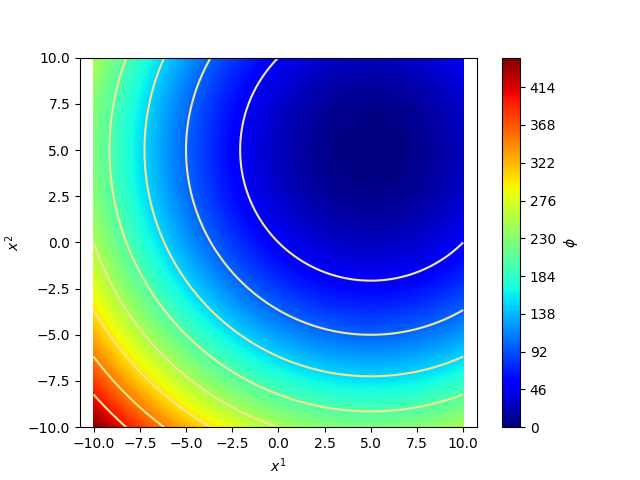

In [5]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()
norm = matplotlib.colors.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
fig.colorbar(im, ax=ax, label=r"$\phi$")
ax.axis("equal")
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

### Vector Field & Streamlines

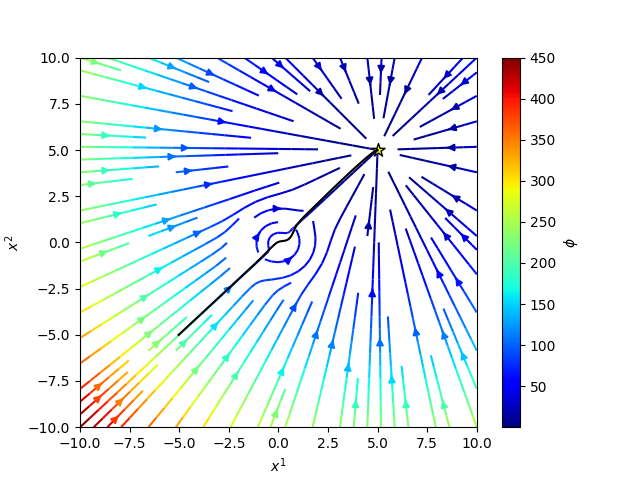

In [6]:
square = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
semi_circle = Obstacles.semi_circle(radius=10, center=torch.tensor([-20,20]), rot=torch.tensor(torch.pi/4), res=100)
point = torch.tensor([[0.0,0.0]])
phi = KernelExpansion(point.to(device), kernel=SquaredExp(l=1.0)).to(device)
phi.weights = 10.0*torch.ones(point.shape[0]).to(device)
embedding.local_deformation = phi

field = model(torch.cat((grid_x,grid_v),dim=1))
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

x0 = TorchHelper.grid_uniform(center=torch.tensor([-5,-5]).to(device), length=0.03, samples=1).to(device).requires_grad_(True)
v0 = torch.zeros_like(x0).to(device).requires_grad_(True)
streamlines = Integrator.second_order(dynamics=model,x0=torch.cat((x0,v0),dim=1),T=20, dt=0.01).cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet")
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k')
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=100, edgecolors='k', c='yellow', marker="*")
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
fig.colorbar(mappable,  ax=ax, label=r"$\phi$")

### Embedding

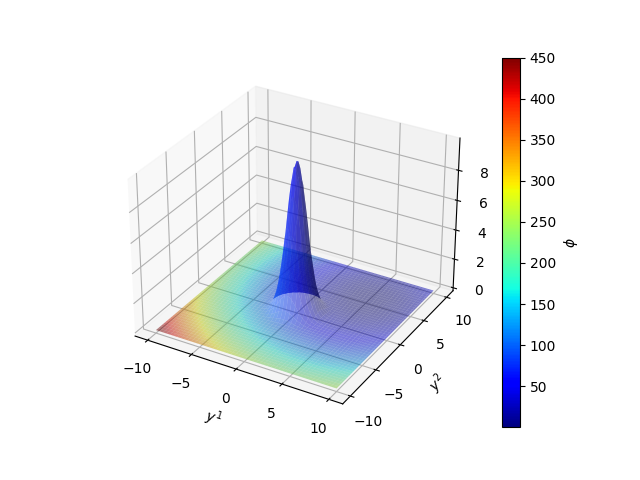

In [7]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
im = ax.plot_surface(x_embedding, y_embedding, z_embedding,facecolors=colors, antialiased=True, linewidth=0, alpha=0.5)
ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')
fig.colorbar(mappable, ax=ax, label=r"$\phi$")

### Metric

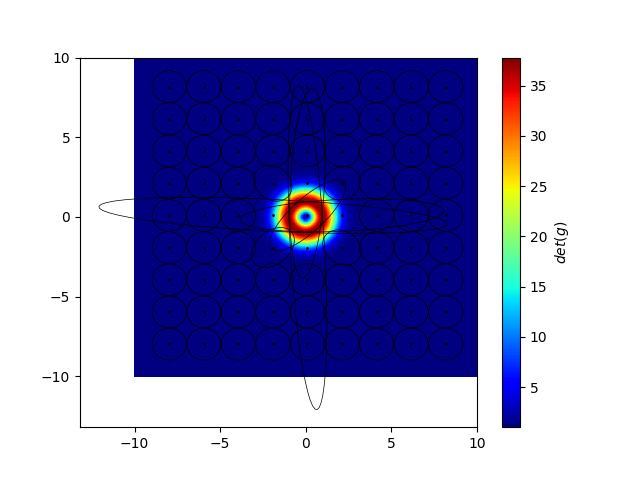

In [8]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)
ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

norm = matplotlib.colors.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(x, y, det_metric, 500, cmap="jet")
ax.scatter(x[10::10,10::10,], y[10::10,10::10], color="k", s=1)

for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i,:], ellipses_y[i,:], color="k", linewidth=0.5)

fig.colorbar(mappable,  ax=ax, label=r"$det(g)$")